In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import shap

 Reproduction du model en production

In [2]:
housing = fetch_california_housing(as_frame=True)
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.15, max_depth=5, random_state=42)
model.fit(X_train, y_train)
columns = X.columns

GradientBoostingRegressor(learning_rate=0.15, max_depth=5, n_estimators=150,
                          random_state=42)

# Analyse global

La dépendance partielle montre la relation entre une ou plusieurs caractéristiques (features) et la prédiction moyenne du modèle, tout en "neutralisant" l'effet des autres caractéristiques. Elle répond à la question : Comment les prédictions changent-elles en fonction d'une caractéristique donnée, en moyenne ?

Limites :
Indépendance des caractéristiques : Suppose que les caractéristiques sont indépendantes, ce qui n'est pas toujours vrai dans les données réelles.
Les interactions entre variables ne sont pas directement visibles.

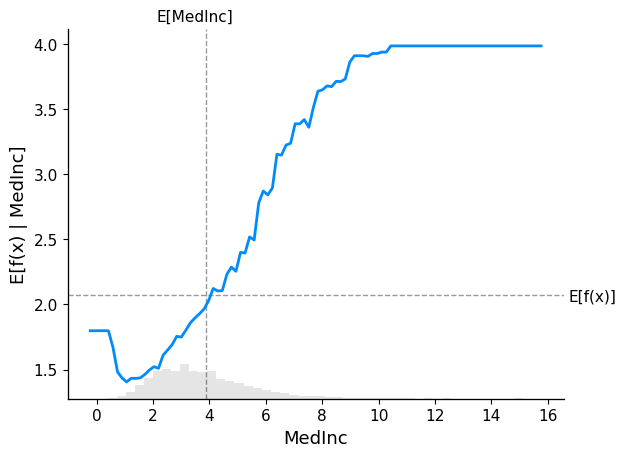

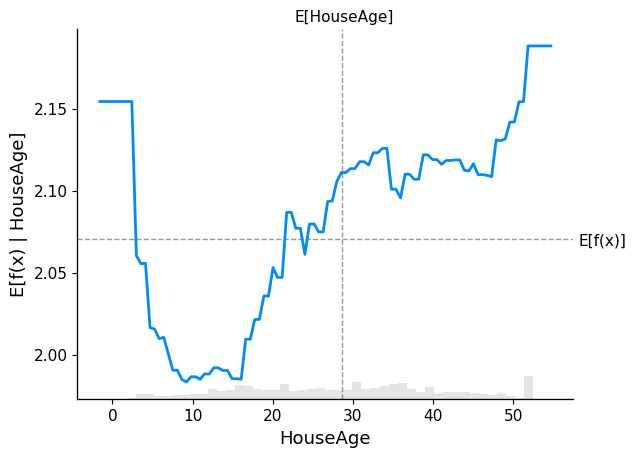

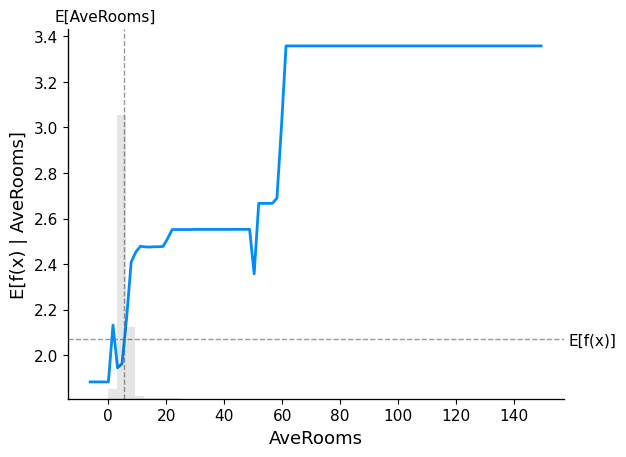

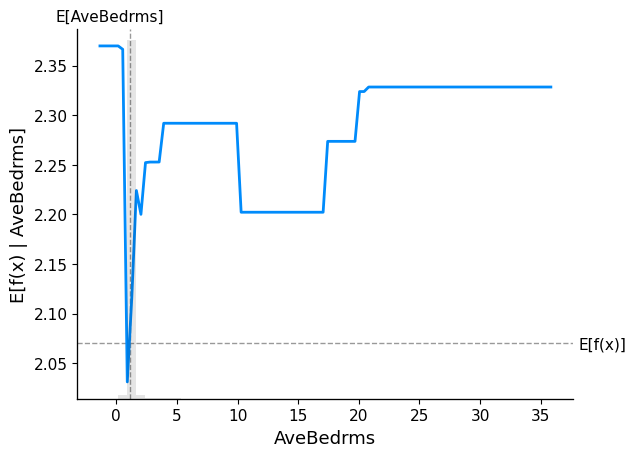

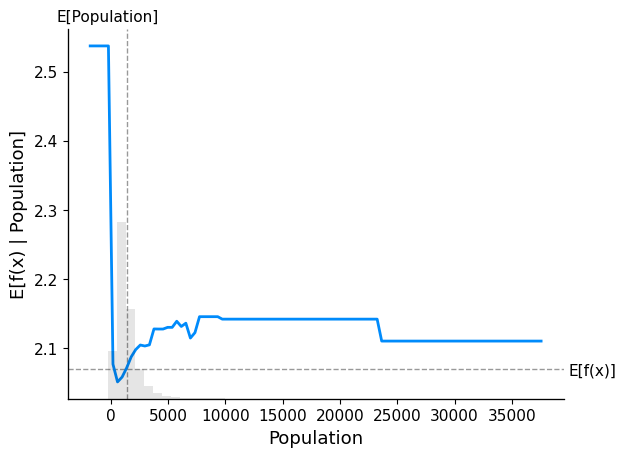

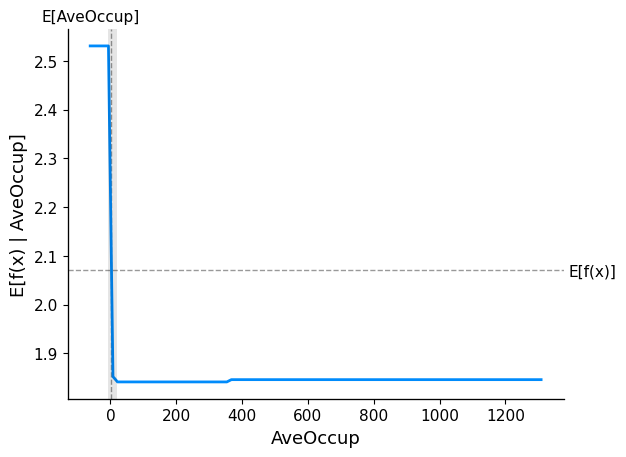

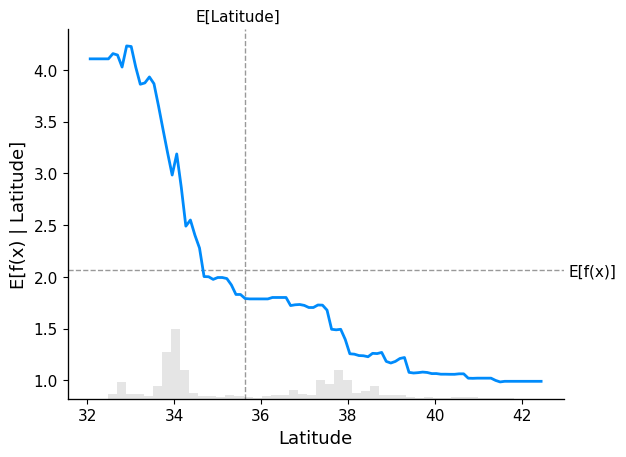

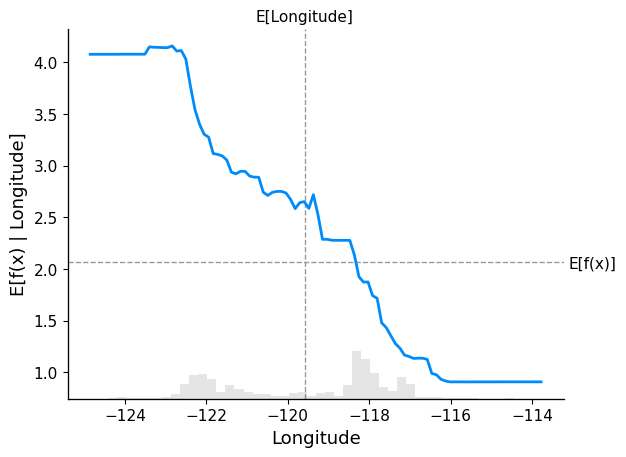

In [4]:
for col in columns:
    shap.partial_dependence_plot(
    col,
    model.predict,
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

**MedInc (Revenu Médian par Groupe)**
On observe une corrélation positive entre le revenu médian et la valeur médiane des maisons. Plus le revenu médian augmente, plus la valeur moyenne des prédictions des maisons croît. Cela confirme les observations faites lors de l’analyse exploratoire des données.

---

**HouseAge (Âge des Maisons)**
La relation entre l’âge des maisons et leur valeur suit une courbe en forme de U. Les maisons neuves sont estimées avec une valeur plus élevée que celles ayant entre 5 et 20 ans. Cependant, à mesure que l'âge des maisons augmente au-delà de 20 ans, leur valeur moyenne tend à augmenter progressivement. Cela suggère qu'un âge avancé peut également être perçu comme une marque de caractère ou de localisation avantageuse.

---

**AveRooms (Nombre Moyen de Pièces par Logement)**
La valeur médiane des maisons augmente de manière significative avec le nombre moyen de pièces par logement, suivant des paliers bien distincts :
- Les logements ayant entre **1 et 3 pièces** sont en moyenne évalués à **200 000 dollars**.
- Ceux ayant entre **3 et 60 pièces** atteignent en moyenne **260 000 dollars**.
- Enfin, les logements avec plus de **60 pièces** sont estimés autour de **340 000 dollars**.  
Ces observations montrent que la taille des logements a un impact notable sur leur valeur.

---

**AveBedrms (Nombre Moyen de Chambres par Logement)**
La valeur médiane des maisons varie légèrement par paliers en fonction du nombre moyen de chambres :
- Les logements ayant entre **1 et 10 chambres** sont estimés en moyenne à **230 000 dollars**.
- Ceux ayant entre **10 et 17 chambres** voient leur valeur légèrement diminuer à **220 000 dollars**.
- Enfin, au-delà de **17 chambres**, la valeur augmente à nouveau pour atteindre **235 000 dollars**.  
Cette variation peut s’expliquer par des interactions complexes entre le nombre de chambres et d'autres caractéristiques, comme la surface totale.

---

**Population (Densité de Population)**
La densité de population n’a qu’un impact limité sur la valeur médiane des maisons. La valeur des biens augmente légèrement avec la densité de population, mais seulement jusqu’à un certain seuil, au-delà duquel elle stagne. Cela suggère que la densité seule n’est pas un facteur décisif dans la détermination des prix immobiliers.

---

**AveOccup (Nombre Moyen de Personnes par Logement)**
Le nombre moyen de personnes par logement semble avoir une influence très faible sur les prédictions. La valeur moyenne des biens reste presque constante, quel que soit ce nombre. Cela est logique, car la valeur immobilière dépend principalement de la localisation et des caractéristiques physiques des biens, plutôt que du nombre de personnes qui y résident.

---

**Latitude**
La valeur des biens immobiliers diminue de manière progressive à mesure que la latitude augmente. Cela confirme l’hypothèse formulée lors de l’analyse exploratoire : les biens situés plus au sud, proches des zones côtières, ont des valeurs plus élevées. Cela reflète la forte demande pour les zones proches de l’océan Pacifique.

---

**Longitude**
De manière similaire à la latitude, la valeur des biens diminue lorsque la longitude augmente, c’est-à-dire en s’éloignant de la côte californienne. Cette observation est cohérente avec les villes comme **San Diego**, **Los Angeles**, **San Jose**, ou **San Francisco**, où les prix immobiliers sont nettement plus élevés en raison de leur proximité avec la mer et leur attractivité économique.

# Analyse local

Définition :
Les valeurs SHAP mesurent la contribution exacte de chaque caractéristique à la prédiction d'une observation spécifique, en utilisant les valeurs de Shapley issues de la théorie des jeux.

Méthode :
Pour une observation donnée, les valeurs SHAP calculent la différence entre la prédiction obtenue avec et sans chaque caractéristique, en considérant toutes les combinaisons possibles.
Les valeurs SHAP sont additives : la somme des contributions de toutes les caractéristiques est égale à la prédiction finale moins la valeur de base (expected value).

Utilisation :
Explications locales (par observation) et globales (en agrégeant les valeurs SHAP).
Répondre à la question : Pourquoi ce modèle a-t-il fait cette prédiction pour cette observation ?
Exemple :
Pour une observation où la prédiction est élevée, les valeurs SHAP vous diront quelles caractéristiques ont poussé la prédiction à augmenter (et de combien), et lesquelles l'ont fait baisser.

Avantages :
Interactions : Les valeurs SHAP prennent en compte les interactions entre caractéristiques.
Applicables aux explications locales et globales.

In [5]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 4129it [04:22, 15.32it/s]                          


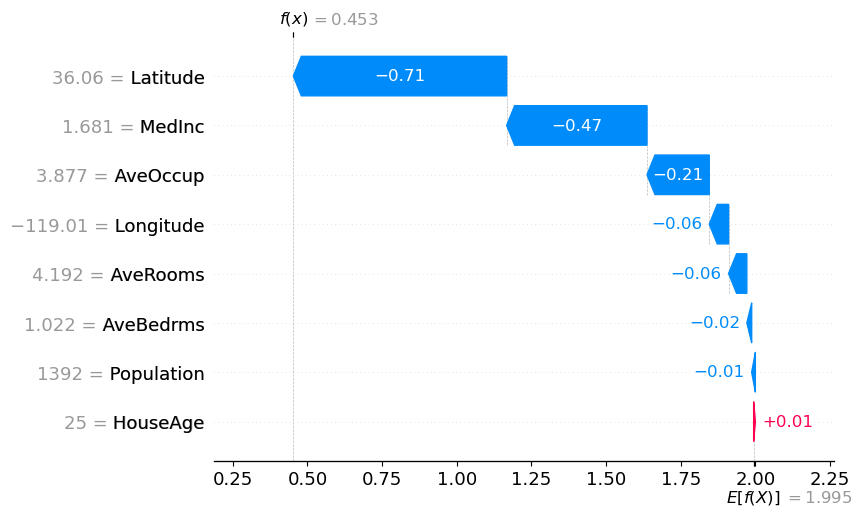

In [13]:
sample_ind = 0
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

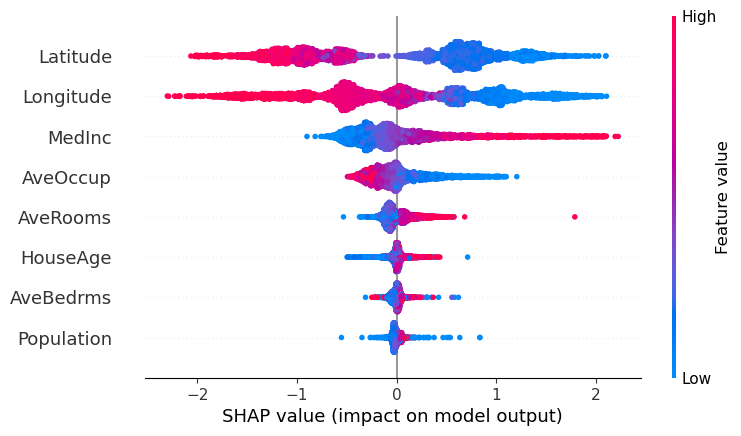

In [8]:
shap.plots.beeswarm(shap_values)

Le graphique des valeurs SHAP présenté ci-dessus confirme les résultats obtenus lors de l'analyse des dépendances partielles. Les variables qui influencent le plus les prédictions du modèle sont **Latitude**, **Longitude**, et **MedInc**. Ces caractéristiques jouent un rôle clé dans la détermination des valeurs médianes des maisons.

Ensuite, des variables comme **AveOccup** et **AveRooms** exercent une influence moindre, mais non négligeable.
  
Enfin, **HouseAge**, **Population**, et **AveBedrms** ont une contribution très faible, indiquant qu'elles impactent peu les prédictions du modèle.

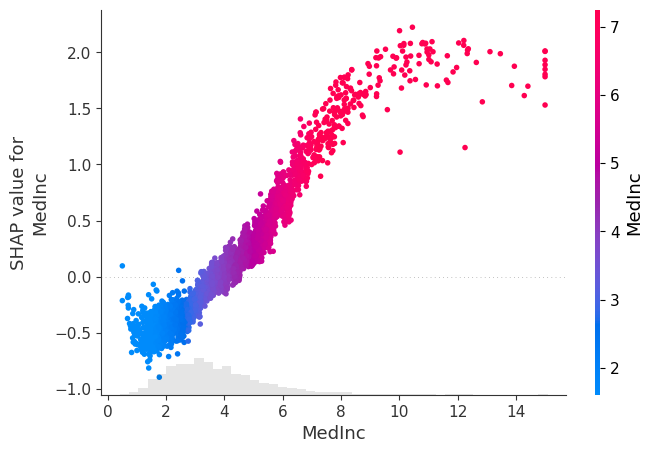

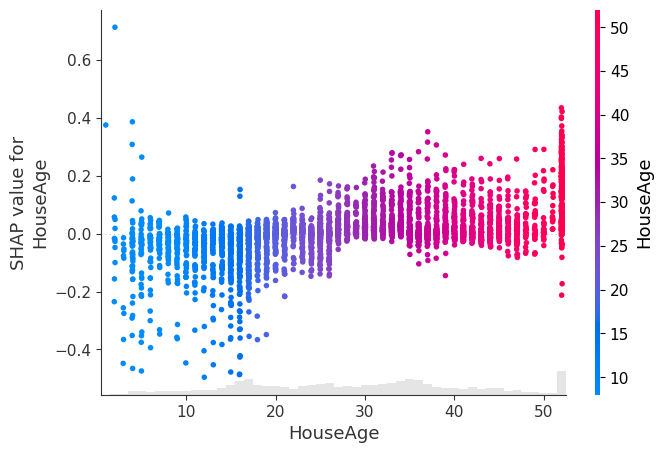

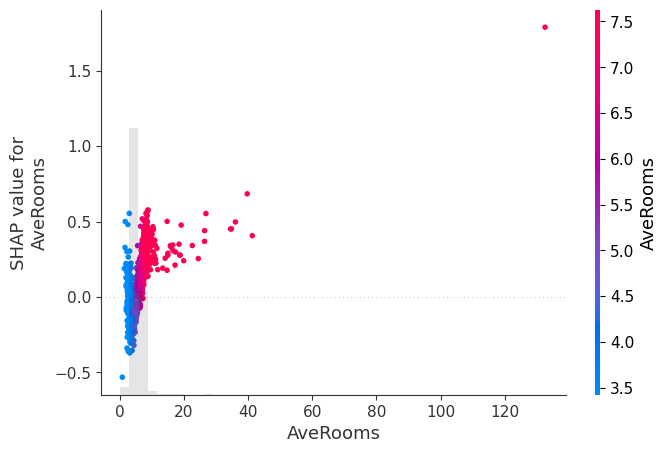

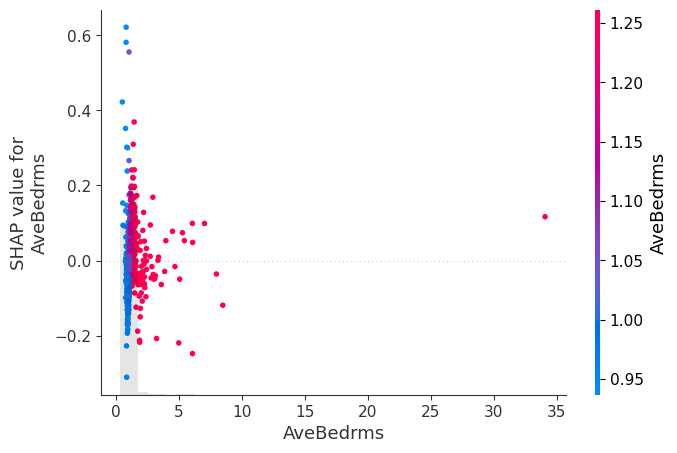

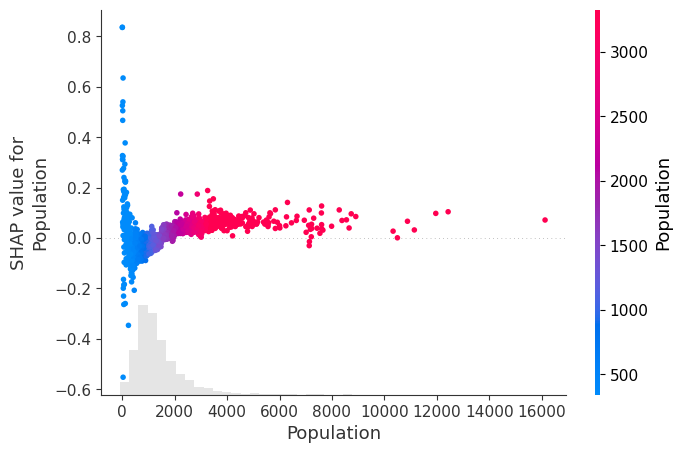

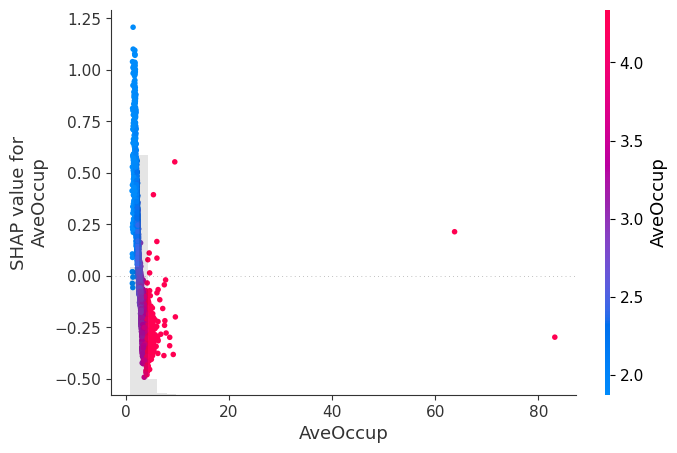

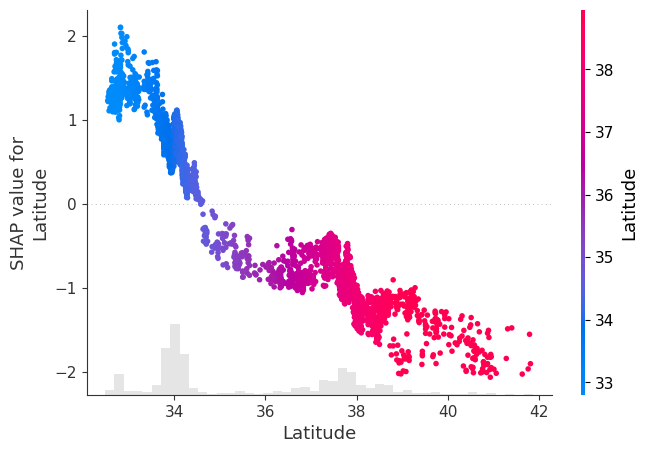

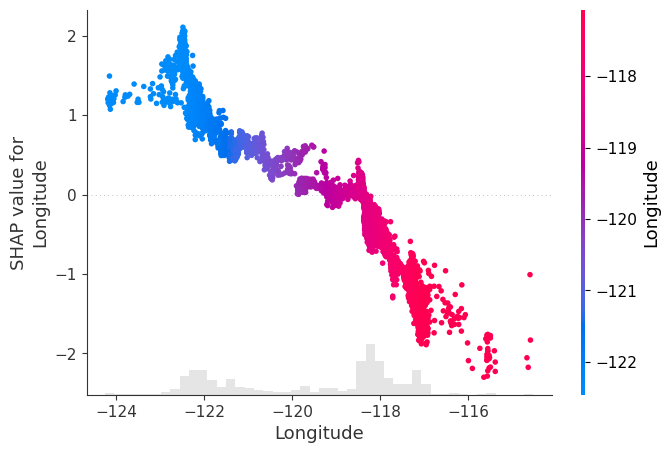

In [12]:
for col in columns:
    shap.plots.scatter(shap_values[:, col], color=shap_values[:, col])

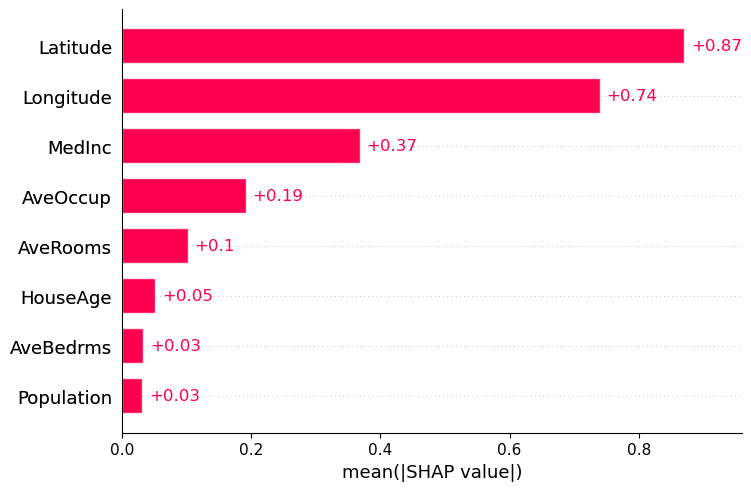

In [10]:
shap.plots.bar(shap_values)

Ce graphique montre qu’en moyenne, les caractéristiques **Latitude**, **Longitude**, **MedInc**, **AveOccup**, **AveRooms**, **HouseAge**, **Population**, et **AveBedrms** contribuent respectivement, en valeur absolue, à hauteur de **0,87**, **0,74**, **0,37**, **0,19**, **0,10**, **0,05**, **0,03**, et **0,03** à la prédiction du modèle par rapport à la baseline.  
Ces résultats confirment l’importance relative des variables identifiées précédemment, avec une influence majeure des trois premières caractéristiques (**Latitude**, **Longitude**, et **MedInc**) et une contribution plus marginale des autres.

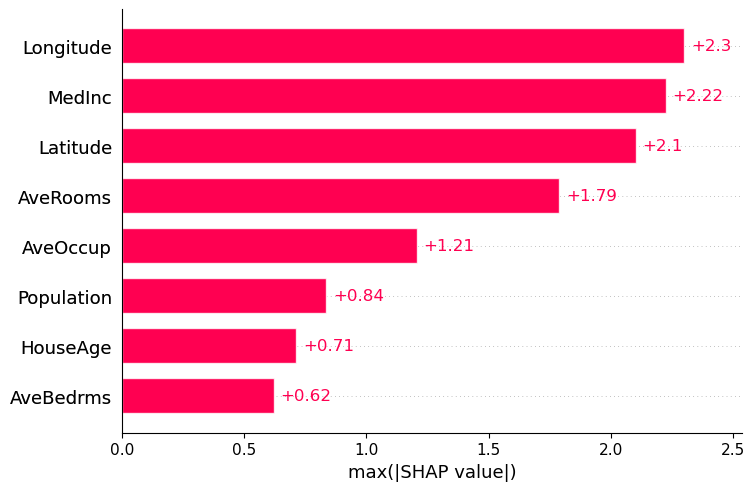

In [11]:
shap.plots.bar(shap_values.abs.max(0))

Ce graphique illustre que les caractéristiques **Latitude**, **Longitude**, **MedInc**, **AveOccup**, **AveRooms**, **HouseAge**, **Population**, et **AveBedrms** contribuent, en valeur absolue, à hauteur de **2.3**, **2.22**, **2.1**, **1.79**, **1.21**, **0.84**, **0.71**, et **0.62** respectivement à la prédiction du modèle par rapport à la baseline.

**Interprétation** :
- Les caractéristiques **Latitude**, **Longitude**, et **MedInc** ont les contributions les plus élevées, avec des valeurs proches de **2**, ce qui suggère qu'elles jouent un rôle majeur dans la détermination des prédictions du modèle. En particulier, cela indique que la **localisation géographique** (latitude et longitude) et le **revenu médian** influencent de manière significative la valeur prédite des maisons.
- **AveOccup**, **AveRooms**, et **HouseAge** montrent des contributions modérées, impliquant qu’elles sont également importantes, mais dans une moindre mesure. Leur impact est notable, mais moins central comparé aux premières caractéristiques.
- **Population** et **AveBedrms** ont les contributions les plus faibles, mais leur effet reste non négligeable. Ces variables semblent avoir un impact plus subtil sur la prédiction finale, sans être aussi influentes que celles liées à la géographie et au revenu.

En résumé, la géographie et le revenu médian sont les facteurs clés qui déterminent principalement les prédictions du modèle, tandis que les autres caractéristiques contribuent de manière plus modérée. 


**Observont les shap value pour quelques observation**

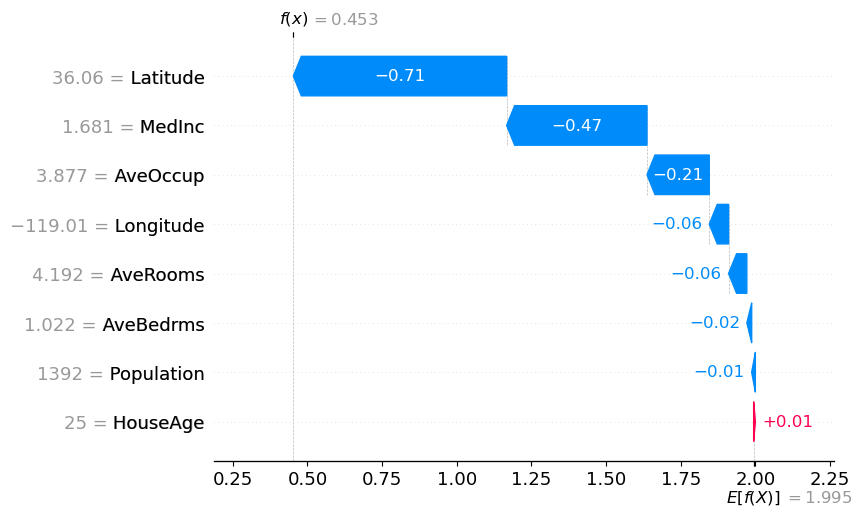

In [14]:
sample_ind = 0
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

**Latitude** (36.06):
   - **Impact**: -0.71
   - **Interprétation**: 
     - Cette valeur de latitude a eu le plus grand impact négatif sur la prédiction. Cela signifie que, dans ce modèle, des latitudes similaires à 36.06 sont associées à une diminution de la valeur prédite (f(X)). 
     - Il est probable que cette latitude soit dans une région où les valeurs de la cible (par exemple, prix ou autre métrique) tendent à être plus faibles.

---

**MedInc** (1.681):
   - **Impact**: -0.47
   - **Interprétation**:
     - La médiane des revenus (MedInc) pour cet exemple a également un impact significatif négatif sur la prédiction. Une valeur de 1.681 est relativement basse (par rapport aux données d'entraînement), ce qui semble diminuer la valeur prédite.
     - Le modèle semble considérer que des revenus plus faibles entraînent des valeurs prédites plus basses.

---

**AveOccup** (3.877):
   - **Impact**: -0.21
   - **Interprétation**:
     - La valeur moyenne d'occupation par logement (AveOccup) a une contribution négative modérée. Une valeur de 3.877 semble indiquer une densité d'occupation qui réduit légèrement la prédiction.
     - Cela pourrait suggérer que les zones avec une occupation moyenne similaire sont associées à des cibles plus basses.

---

**Longitude** (-119.01):
   - **Impact**: -0.06
   - **Interprétation**:
     - La longitude a une petite influence négative sur la prédiction. Une longitude de -119.01 semble être associée à une réduction de la valeur prédite, mais l'impact reste limité.
     - Cela pourrait refléter une région géographique où la cible est légèrement plus faible.

---

**AveRooms** (4.192):
   - **Impact**: -0.06
   - **Interprétation**:
     - Le nombre moyen de pièces par logement (AveRooms) a également une contribution légèrement négative. Une valeur de 4.192 indique probablement un logement moyen ou modeste qui contribue peu à la réduction de la prédiction.

---

**AveBedrms** (1.022):
   - **Impact**: -0.02
   - **Interprétation**:
     - Le nombre moyen de chambres par logement (AveBedrms) a un impact très faible et négatif. Cela signifie que pour cet échantillon, la proportion de chambres influence à peine la prédiction.

---

**Population** (1392):
   - **Impact**: -0.01
   - **Interprétation**:
     - La population de la zone (Population) n'a presque aucun effet sur la prédiction, avec un impact négatif négligeable. Ce facteur semble peu influent pour ce cas particulier.

---

**HouseAge** (25):
   - **Impact**: +0.01
   - **Interprétation**:
     - L'âge moyen des maisons dans la zone (HouseAge) est le seul facteur avec un impact **positif**, mais il est minime. Une valeur de 25 ans semble légèrement augmenter la prédiction.
     - Cela pourrait indiquer que dans cette région, des maisons d'âge similaire sont faiblement corrélées avec des valeurs cibles plus élevées.

---

### Synthèse
- **Latitude** et **MedInc** sont les facteurs dominants qui **réduisent** la prédiction.
- **HouseAge** est le seul facteur qui **augmente** légèrement la prédiction, mais son impact est faible.
- Les autres caractéristiques, comme **AveOccup**, **Longitude**, et **AveRooms**, jouent un rôle mineur dans la prédiction pour cet exemple.

Ces analyses montrent que la prédiction est principalement influencée par des variables géographiques et économiques, avec une contribution mineure des autres facteurs démographiques ou liés au logement.